In [205]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.patches as patches

import pylab as plt
#!pip install --user gpy 
#!pip install --user plotly 

import GPy
from IPython.display import display

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering
from sklearn.cluster import DBSCAN




#GPy.plotting.change_plotting_library('plotly')
GPy.plotting.change_plotting_library('plotly_offline')

sns.set(color_codes=True)

### Load data
Load raw data, drop some values missed in data preparation, drop unnecessary columns, show data head

In [153]:
data_raw = pd.read_csv('data/cleaned_data2.csv').drop(columns=['Unnamed: 0'])
print(len(data_raw))

# Drop some bad samples from data
data_raw = data_raw[data_raw.number_of_rooms != ' ']
data_raw = data_raw[data_raw.dist_center < 100]

# Drop na
data_raw = data_raw.dropna()
print(len(data_raw))  # a lot of na, impute values?

# Drop unnecessary columns, they are still in data_raw if needed later
data = data_raw.drop(columns=['neighborhood', 'rooms', 'energy_class'])
data.head(5)

3432
2242


,type_kt,type_rt,type_ok,elevator,price,price_per_square_meter,number_of_rooms,square_meters,year,condition,floor_num,top_floor,bottom_floor,floor_frac,lat,lng,dist_center
0,1,0,0,1,191050,10055,1,19.0,1929,2,5.0,True,False,1.000000,60.167458,24.931075,0.485608
2,1,0,0,1,167000,6680,1,25.0,1940,1,6.0,True,False,1.000000,60.188258,24.955949,2.270341
3,1,0,0,0,157000,6181,1,25.4,1951,1,1.0,False,False,0.250000,60.202747,24.905494,4.093763
5,1,0,0,1,181500,6259,1,29.0,1963,2,2.0,False,False,0.500000,60.221863,24.896194,6.249120
6,1,0,0,0,186000,6414,1,29.0,1943,2,1.0,False,False,0.333333,60.214163,24.950781,4.984236


## Data exploration
In this section we explore the data to get a better understanding of it

### Plot variables
Next, we plot some variables to get a feel for the dataset. The goal of this project is to predict price per $m^2$, so most of the plots have that variable on y axis

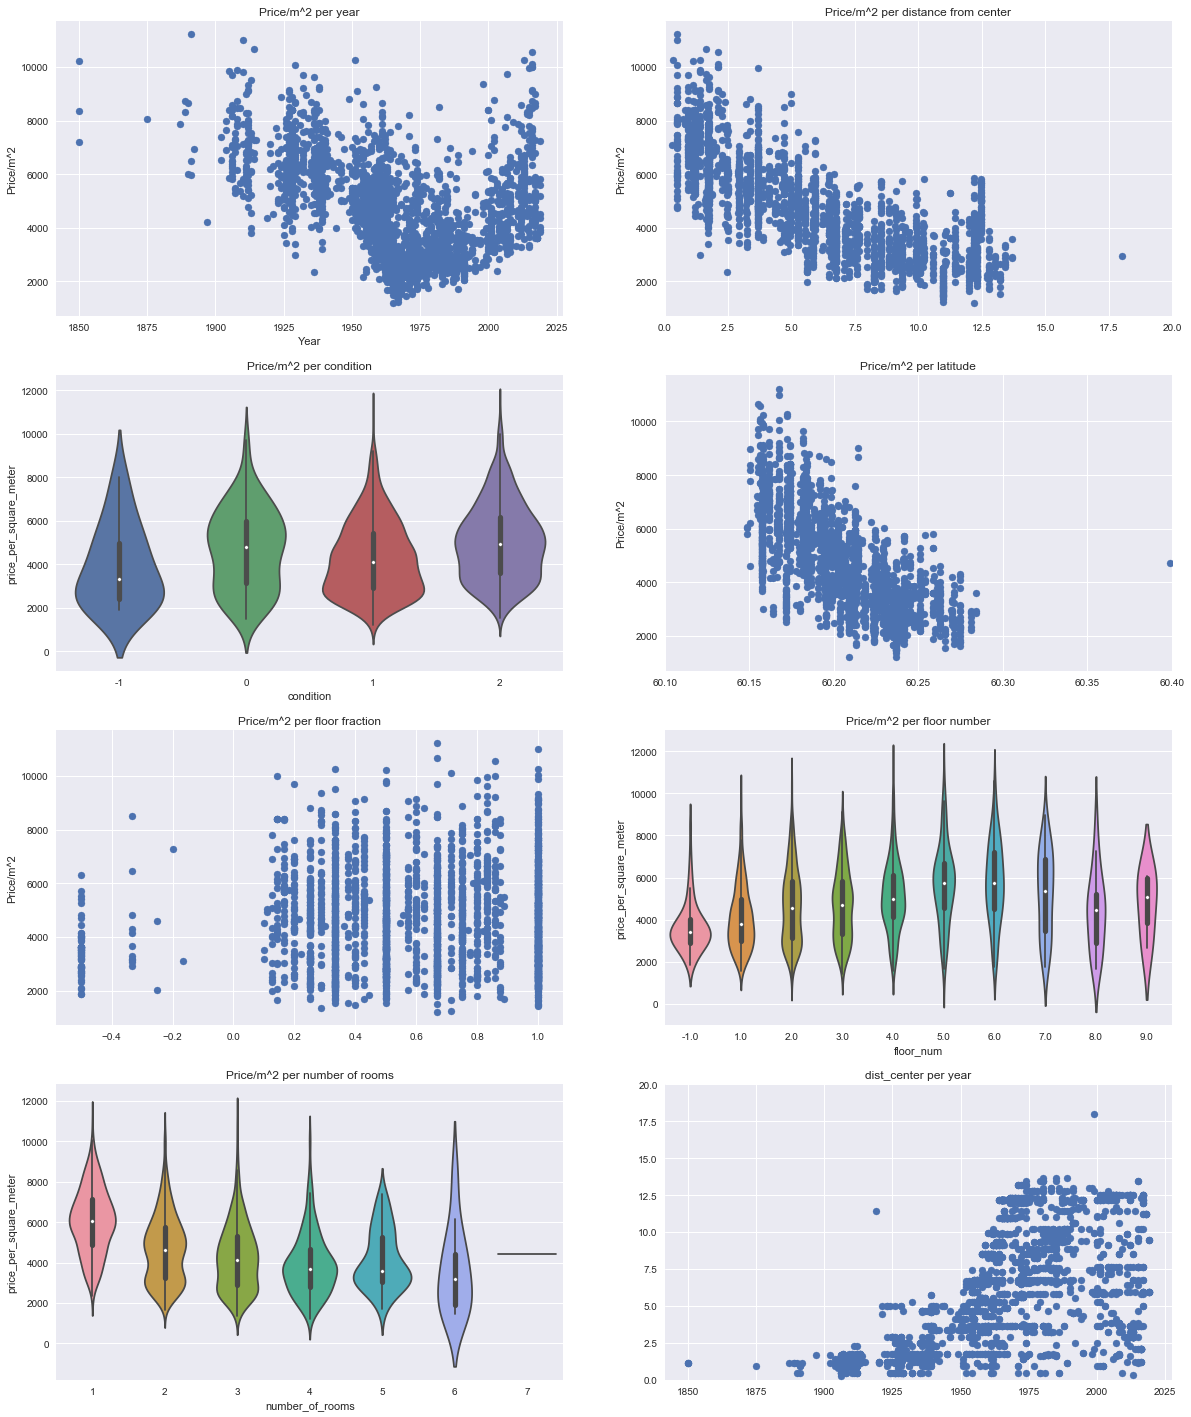

In [199]:
# Plot some shit
plt.figure(figsize=(20, 25))
plt.subplot(4,2,1)
plt.title('Price/m^2 per year')
plt.xlabel('Year')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='year', y='price_per_square_meter')

plt.subplot(4,2,2)
plt.xlim(0, 20)
plt.title('Price/m^2 per distance from center')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='dist_center', y='price_per_square_meter')

plt.subplot(4,2,3)
#plt.xlim(0, 20)
plt.title('Price/m^2 per condition')
plt.ylabel('Price/m^2')
sns.violinplot(data=data, x='condition', y='price_per_square_meter')

plt.subplot(4,2,4)
plt.xlim(60.1, 60.4)
plt.title('Price/m^2 per latitude')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='lat', y='price_per_square_meter')

plt.subplot(4,2,5)
plt.title('Price/m^2 per floor fraction')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='floor_frac', y='price_per_square_meter')

plt.subplot(4,2,6)
plt.title('Price/m^2 per floor number')
sns.violinplot(data=data, x='floor_num', y='price_per_square_meter', jitter=True)

plt.subplot(4,2,7)
plt.title('Price/m^2 per number of rooms')
sns.violinplot(data=data, x='number_of_rooms', y='price_per_square_meter', jitter=True)

plt.subplot(4,2,8)
plt.title('dist_center per year')
plt.ylim(0, 20)
plt.scatter(data=data, x='year', y='dist_center')


#plt.savefig('fig/year_price_scatter.eps', format='eps')

### Correlation plot
Correlation plot gives nice overview of the variable correlations. Interesting observations include that price per square meter and price differ on a number of variables, such as house type. Year and distance from city center also correlate.

Text(0.5,1,'Correlation plot')

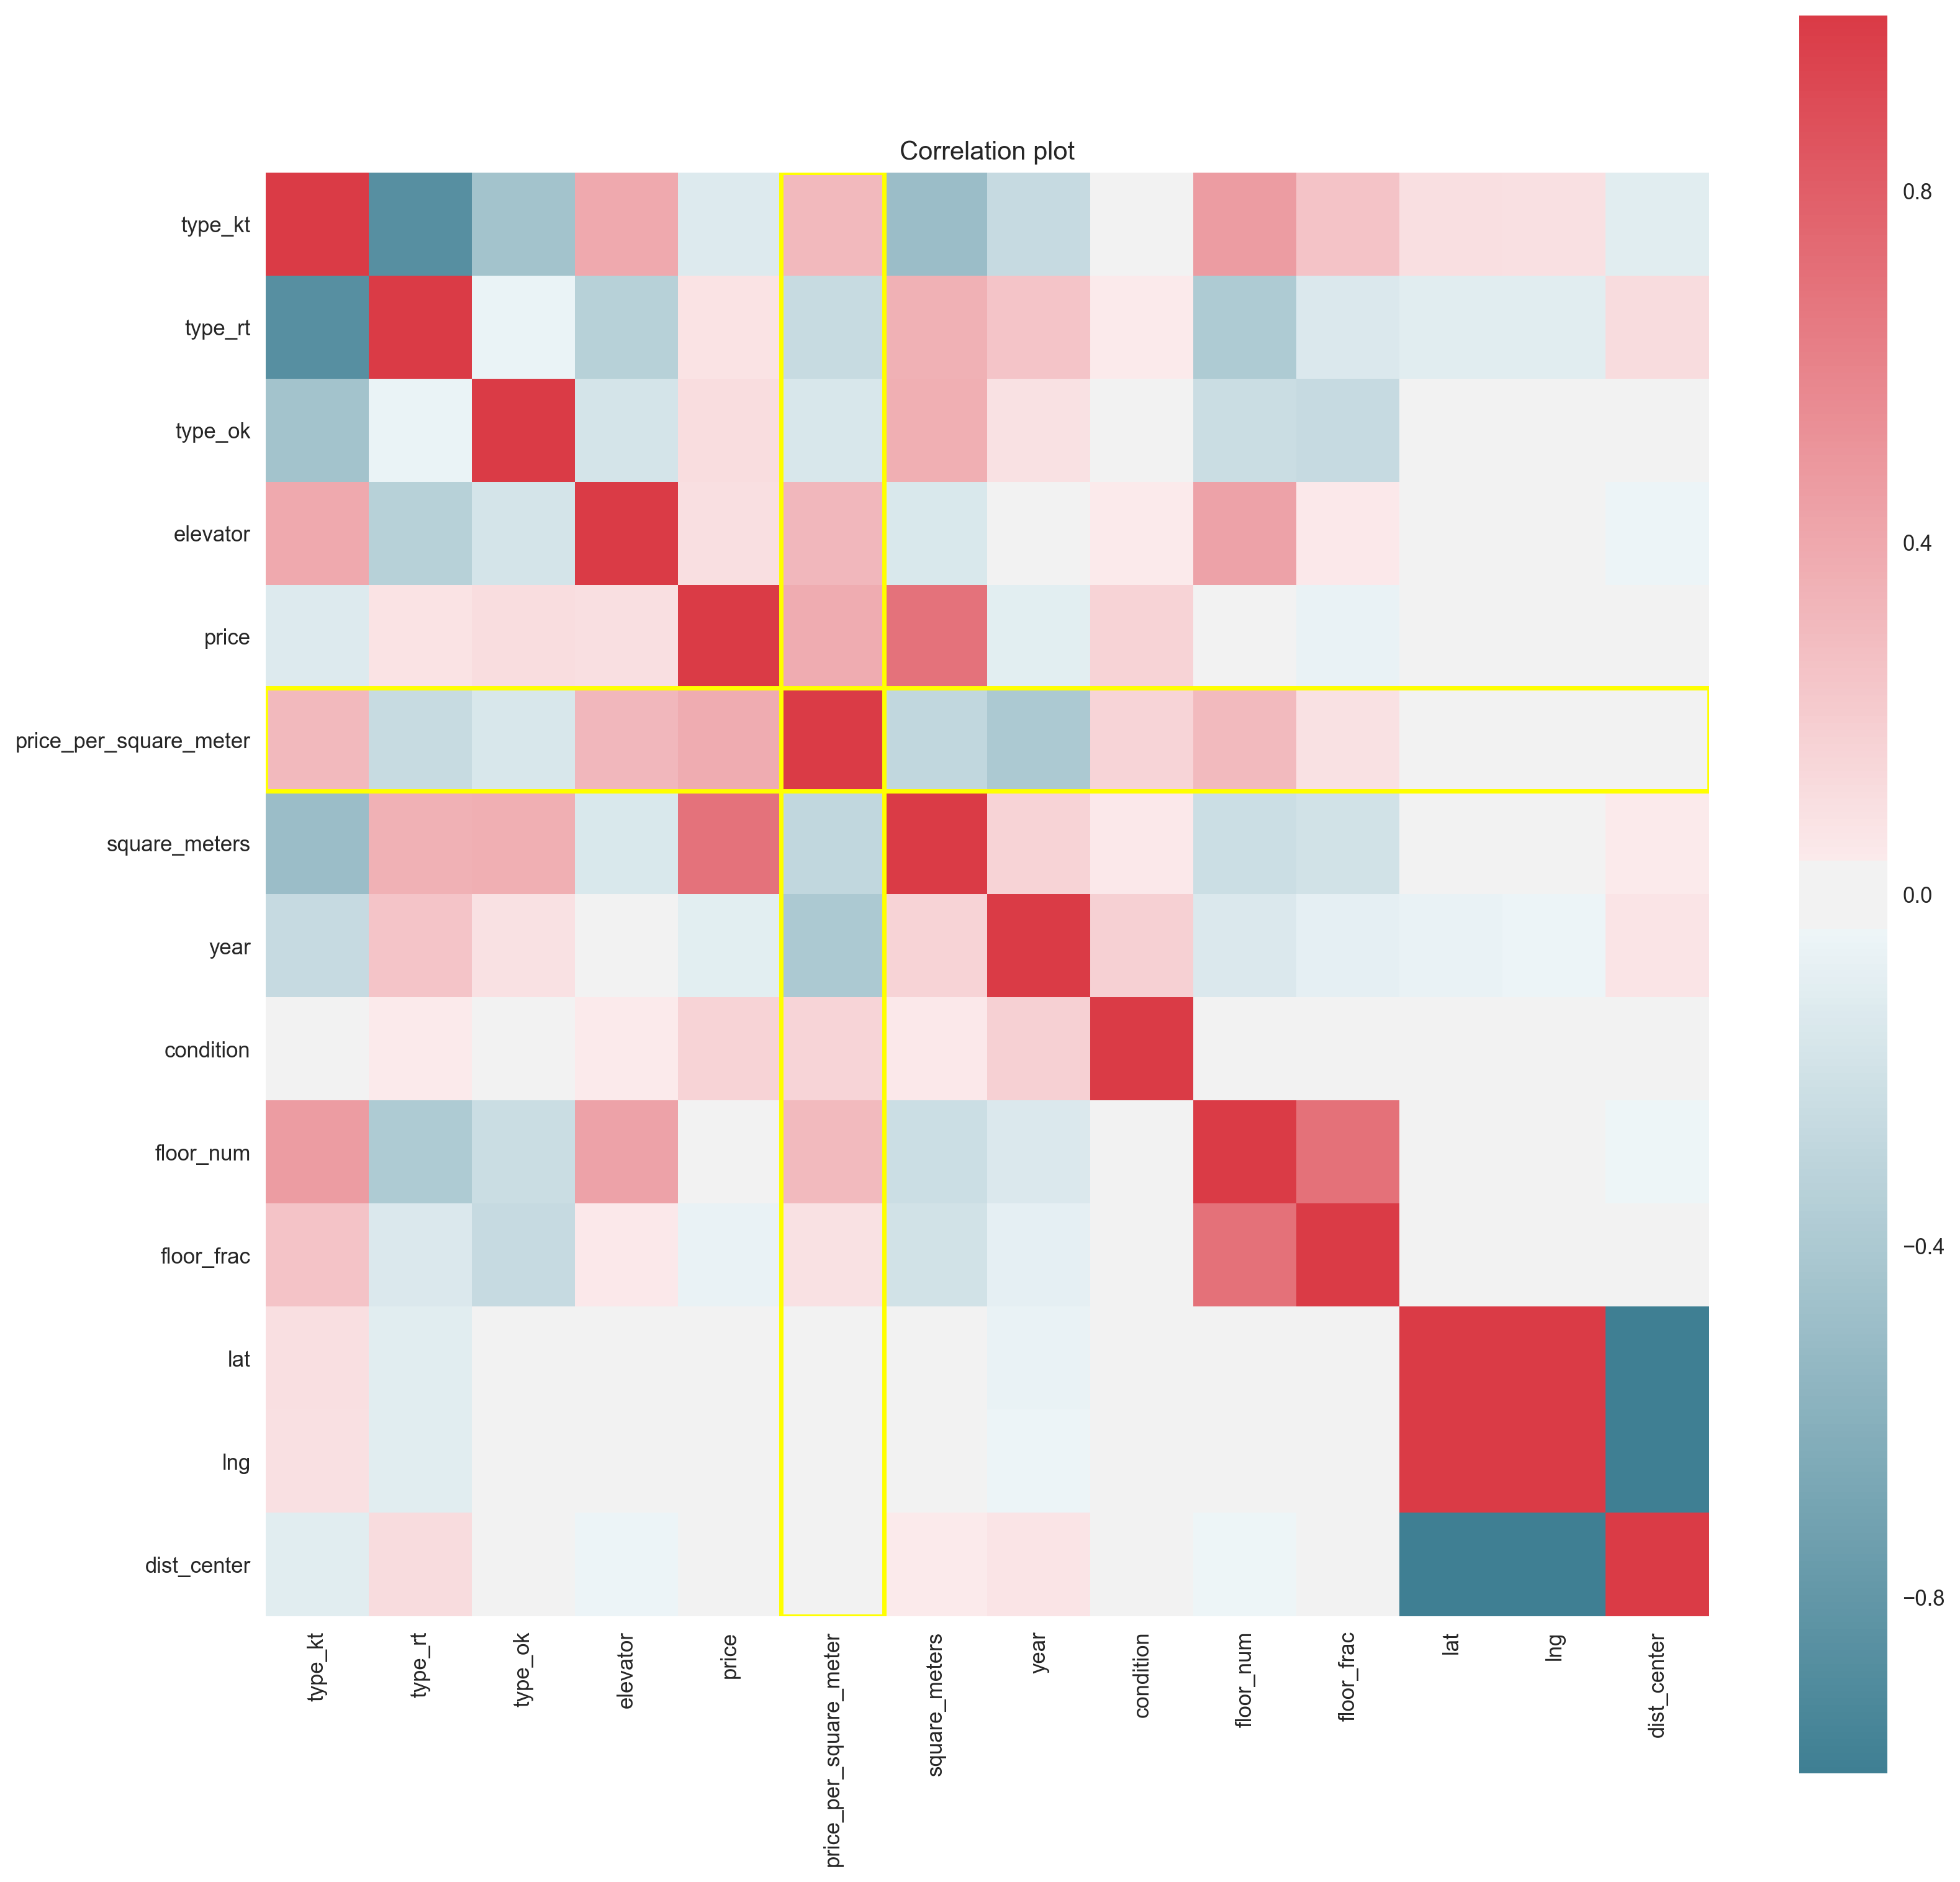

In [75]:
corr = data.corr()
f, ax = plt.subplots(figsize=(15, 15), dpi=250)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

ax.add_patch(
    patches.Rectangle(
        (5, 0),
        1,
        14,
        fill=False,
        linewidth=2,
        color='yellow'
    )
)
ax.add_patch(
    patches.Rectangle(
            (0, 5),
            14,
            1,
            fill=False,
            linewidth=2,
            color='yellow'
    )
)

plt.title('Correlation plot')

### TSNE embedding
Next, we do tsne embedding to visualize the whole dataset in 2D. Price related variables are dropped as we wish to predict those variables and as such can use them to color the tsne plots to see if any clusters form where the price or price per square meter are different.

We plot a couple of more tsne plots where the coloring is some other interesting variable.

The resulting plots show somewhat neat clusters. In the bottom row, they are colored based on kmeans and DBSCAN clustering algorithm. For example, it seems that the top left cluster represents new houses in good condition. The two clusters on the right represent older houses in varying conditions near the center of the city.

The results suggest that neighbor or distance based models might perform well on this task. 

In [154]:
# TSNE, drop price and price per square meter as we want to predict those variables
data_tsne_embedded = TSNE(n_components=2).fit_transform(data.drop(columns=['price', 'price_per_square_meter']))

In [218]:
# Calculate kmeans and spectral clusters on the data for cluster visualization
kmeans = KMeans(n_clusters=8).fit(data_tsne_embedded)
kmeans_labels = kmeans.labels_

dbscan_labels = DBSCAN(eps=3).fit_predict(data_tsne_embedded)

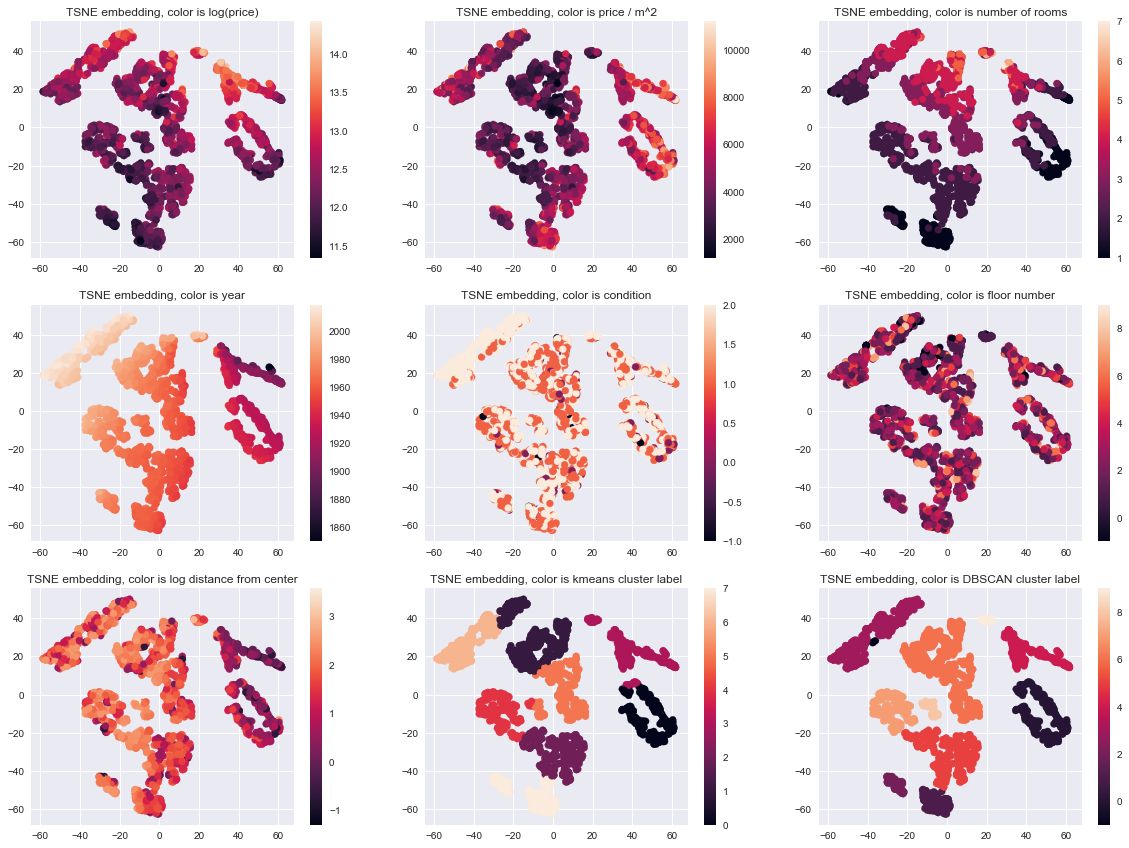

In [224]:
plt.figure(figsize=(20, 20))
plt.subplot(4,3,1)
plt.title('TSNE embedding, color is log(price)')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = np.log(data.price))
plt.colorbar()

plt.subplot(4,3,2)
plt.title('TSNE embedding, color is price / m^2')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.price_per_square_meter)
plt.colorbar()

plt.subplot(4,3,3)
plt.title('TSNE embedding, color is number of rooms')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.number_of_rooms)
plt.colorbar()

plt.subplot(4,3,4)
plt.title('TSNE embedding, color is year')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.year)
plt.colorbar()

plt.subplot(4,3,5)
plt.title('TSNE embedding, color is condition')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.condition)
plt.colorbar()

plt.subplot(4,3,6)
plt.title('TSNE embedding, color is floor number')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.floor_num)
plt.colorbar()

plt.subplot(4,3,7)
plt.title('TSNE embedding, color is log distance from center')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = np.log(data.dist_center))
plt.colorbar()


plt.subplot(4,3,8)
plt.title('TSNE embedding, color is kmeans cluster label')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = kmeans_labels)
plt.colorbar()

plt.subplot(4,3,9)
plt.title('TSNE embedding, color is DBSCAN cluster label')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = dbscan_labels)
plt.colorbar()

### PCA analysis
We next do PCA analysis for the data, similarly to the TSNE embedding. We see that the first two components explain 99.1% of the variance, so most likely it would be beneficial to use just these to fit the GP. 

0.9911998069159134


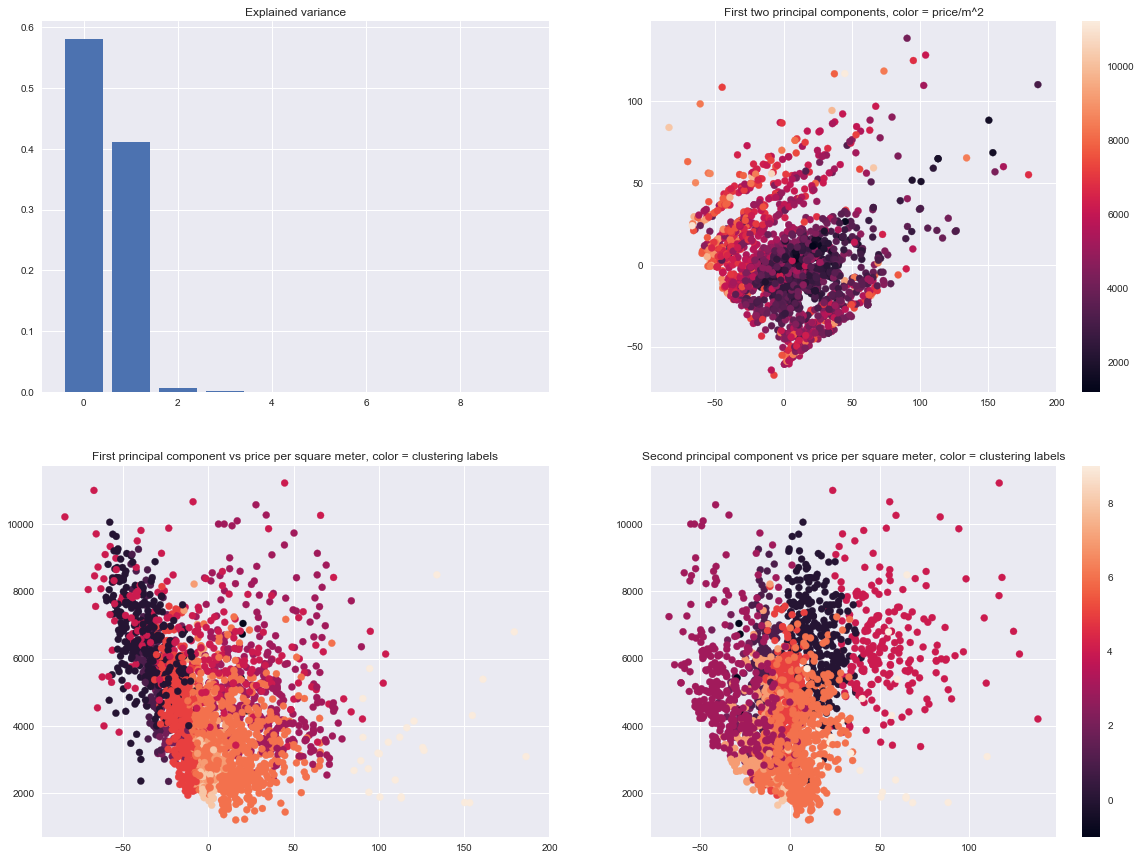

In [237]:
# TSNE, drop price and price per square meter as we want to predict those variables
pca_data = data.drop(columns=['price', 'price_per_square_meter'])

data_pca_model = PCA(n_components=10).fit(pca_data)
data_pca_embedded = PCA(n_components=10).fit_transform(pca_data)

components = data_pca_model.components_
ratios = data_pca_model.explained_variance_ratio_
print(ratios[0]+ ratios[1])

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.bar(np.arange(0,len(ratios)), ratios)
plt.title('Explained variance')

plt.subplot(2,2,2)
plt.title('First two principal components, color = price/m^2')
plt.scatter(x = data_pca_embedded[:,0], y = data_pca_embedded[:,1], c = data.price_per_square_meter)
plt.colorbar()

plt.subplot(2,2,3)
plt.title('First principal component vs price per square meter, color = clustering labels')
plt.scatter(x = data_pca_embedded[:,0], y = data.price_per_square_meter, c = dbscan_labels)

plt.subplot(2,2,4)
plt.title('Second principal component vs price per square meter, color = clustering labels')
plt.scatter(x = data_pca_embedded[:,1], y = data.price_per_square_meter, c = dbscan_labels)
plt.colorbar()

## GAUSSIAN PROCESS FIT

In [143]:
def model_information(model, x_test=None, y_test=None, plot_test_data = False):
    print(model)
 
    log_marginal_likelihood = model.log_likelihood()
    print('\nLog marginal likelihood:')
    print(log_marginal_likelihood)
     
    if x_test is not None and y_test is not None:
        predictions = model.predict(x_test)[0]
        mean_test_error = np.mean((predictions - y_test)**2)
        print('\nMean squared test error:')
        print(mean_test_error)

        mlppd = np.mean(model.log_predictive_density(x_test, y_test))
        print('\nMLPPD:')
        print(mlppd)
 
    fig = model.plot()
        
    if plot_test_data:
        fig_data = fig[0]['data']
        test_info = {'type': 'scatter', 
                     'x': np.squeeze(x_test,1), 
                     'y': np.squeeze(y_test,1), 
                     'mode': 'markers', 
                     'showlegend': True, 
                     'marker': {'color': 'red', 'colorscale': None}, 
                     'name': 'Test'}
        fig_data.append(test_info)
        fig[0]['data'] = fig_data
    
    
    GPy.plotting.show(fig)


### Train-test split
We split the complete data to train and test sets. The test set is data from year 2000 onwards.

In [239]:
# Split data to train and test sets
# Predict house prices after 2017
cutoff_year = 2000

train_data = data[data.year < cutoff_year]
test_data = data[data.year >= cutoff_year]

print('Train and test set sizes:')
print(len(train_data), len(test_data))

Train and test set sizes:
1899 343


### GP for price prediction per year
Let's do this boys: http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/sampling_hmc.ipynb
And some other stuff from here: http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/index.ipynb

In [238]:
X_train = np.array(train_data[['year']])
Y_train = np.array(train_data['price_per_square_meter'])[:, None]

X_test = np.array(test_data[['year']])
Y_test = np.array(test_data['price_per_square_meter'])[:, None]

kernel = GPy.kern.RBF(input_dim=X_train.shape[1], variance=1., lengthscale=1.) 

m = GPy.models.GPRegression(X_train, Y_train, kernel)
m.optimize(messages=True)

model_information(m, X_test, Y_test, plot_test_data = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s01  0014   2.975072e+07   2.366783e+11 
    12s81  0026   9.730586e+05   8.816567e+05 
    21s02  0043   3.217109e+04   2.208427e+02 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply




    22s59  0046   3.217109e+04   2.208427e+02 
Runtime:     22s59
Optimization status: Converged


Name : GP regression
Objective : 32171.09230213258
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   33028.07951069622  |      +ve      |        
  rbf.lengthscale          |  239.78921445420565  |      +ve      |        
  Gaussian_noise.variance  |  101255.53452926608  |      +ve      |        

Log marginal likelihood:
-32171.09230213258

Mean squared test error:
11742151.163534634

MLPPD:
-64.4611300840854
This is the format of your plot grid:
[ (1,1) x1,y1 ]



### GP for PCA data
As the first two principal components account for 99% of the variance, we fit a GP to this transform. Now the GP is two dimensional, which makes constructing kernels more difficult.

In [241]:
data_pca_model = PCA(n_components=2).fit(pca_data)

# Construct pca train test sets
pca_train_X = data_pca_model.transform(train_data.drop(columns=['price', 'price_per_square_meter']))
pca_train_Y = np.array(train_data['price_per_square_meter'])[:, None]

pca_test_X = data_pca_model.transform(test_data.drop(columns=['price', 'price_per_square_meter']))
pca_test_Y = np.array(test_data['price_per_square_meter'])[:, None]

In [249]:
kernel = GPy.kern.RBF(input_dim=X_train.shape[1], variance=1., lengthscale=1.) 
kernel += GPy.kern.RBF(input_dim=X_train.shape[1], variance=10., lengthscale=1.) 
kernel += GPy.kern.Linear(input_dim=X_train.shape[1]) 

m = GPy.models.GPRegression(pca_train_X, pca_train_Y, kernel)
m.optimize(messages=True)

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/core/gp.py:87: UserWarning:

Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel



Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s17  0004   5.391985e+08   1.798869e+16 
    04s78  0006   2.983093e+08   1.800199e+15 
    06s38  0008   1.630676e+08   1.906904e+14 
    11s01  0014   2.216134e+07   1.187008e+11 
    16s72  0022   2.362518e+06   2.074647e+07 
    22s62  0030   6.056200e+05   3.334429e+05 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square




    24s08  0032   3.523654e+05   9.722827e+04 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide



    25s58  0034   2.055095e+05           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply



    29s17  0036   3.208992e+05           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:108: RuntimeWarning:

invalid value encountered in greater



    30s72  0038           nan           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:113: RuntimeWarning:

invalid value encountered in greater



    32s03  0040           nan           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/optimization/verbose_optimization.py:160: RuntimeWarning:

invalid value encountered in less



 01m04s97  0088           nan           nan 
 01m26s12  0118           nan           nan 
Runtime:  01m26s12
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'



In [250]:
#Gpy.plotting.show(fig)
model_information(m, pca_test_X, pca_test_Y, plot_test_data = False)


Name : GP regression
Objective : 109779.43234464909
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  sum.rbf.variance         |      10647.572912776926  |      +ve      |        
  sum.rbf.lengthscale      |  5.562684646268137e-309  |      +ve      |        
  sum.rbf_1.variance       |       5943.807838403308  |      +ve      |        
  sum.rbf_1.lengthscale    |        38.5826561838876  |      +ve      |        
  sum.linear.variances     |  5.562684646268137e-309  |      +ve      |        
  Gaussian_noise.variance  |       8325.796155266446  |      +ve      |        

Log marginal likelihood:
-109779.43234464909

Mean squared test error:
4856814.621773249

MLPPD:
-132.70532893538382
This is the format of your plot grid:
[ (1,1) x1,y1 ]



/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square



In [93]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



IndexError: index 1 is out of bounds for axis 1 with size 1

In [94]:


slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing_vertical')



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



TypeError: calculated free_dims [] from visible_dims None and fixed_dims [0] is neither 1D nor 2D

In [95]:
m.optimize(messages=True)
#m.optimize_restarts(num_restarts = 10)

display(m)
fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.930911e+04   4.542646e-08 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:

overflow encountered in expm1




    02s84  0004   1.930911e+04   9.767605e-10 
Runtime:     02s84
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,21247518.197395407,+ve,
rbf.lengthscale,7.1502921456802335,+ve,
Gaussian_noise.variance,1617702.8693236513,+ve,


This is the format of your plot grid:
[ (1,1) x1,y1 ]

